# Self-Implemented LDA Analysis

In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_csv('D:\\Project\\MSA\\MSA-Vstatis\\Data\\Score.csv', encoding='ascii')
print(df.head(20))
print('Displayed first 20 rows of Score.csv')

    Delay_from_due_date  Num_of_Delayed_Payment  Num_Credit_Inquiries  \
0                   3.0                     7.0                   4.0   
1                   3.0                     7.0                   4.0   
2                   3.0                     7.0                   4.0   
3                   5.0                     4.0                   4.0   
4                   6.0                     4.0                   4.0   
5                   8.0                     4.0                   4.0   
6                   3.0                     8.0                   4.0   
7                   3.0                     6.0                   4.0   
8                   3.0                     4.0                   2.0   
9                   7.0                     1.0                   2.0   
10                  3.0                     1.0                   2.0   
11                  3.0                     3.0                   2.0   
12                  3.0                     1.0    

## Data Preprocessing

In [20]:
# 2. Kiểm tra và xử lý giá trị thiếu (nếu có)
df.dropna(inplace=True)  # Loại bỏ các dòng có giá trị NaN

# 3. Xác định biến mục tiêu và các cột cần encode
target_col = "Credit_Score"
categorical_cols = ["Credit_Mix", "Payment_Behaviour", "Payment_of_Min_Amount"]

# 4. Label Encoding cho biến mục tiêu và các cột phân loại
le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col])  # Encode Credit_Score

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Encode các cột phân loại khác
    label_encoders[col] = le

# 5. Tách biến đầu vào (X) và biến mục tiêu (y)
y_scaled = df[target_col]  # Nhãn phân loại
X = df.drop(columns=[target_col])  # Loại bỏ cột mục tiêu khỏi tập feature


# 6. Chuẩn hóa dữ liệu đầu vào
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Áp dụng Standard Scaling

# 7. Chuyển X về DataFrame để dễ thao tác
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
y_scaled_df = pd.DataFrame(y_scaled, columns=[target_col])

# 9. Split data thành train và test set
target_samples = 100

# Create the undersampler
undersampler = RandomUnderSampler(sampling_strategy={0: target_samples, 1: target_samples, 2: target_samples})

# Apply undersampling
X_resampled, y_resampled = undersampler.fit_resample(X_scaled, y_scaled)

# Check the new class distribution
print("Resampled dataset shape:", Counter(y_resampled))

class_counts = Counter(y_resampled)
print("Number of 0s:", class_counts[0])
print("Number of 1s:", class_counts[1])
print("Number of 2s:", class_counts[2])

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


Resampled dataset shape: Counter({0: 100, 1: 100, 2: 100})
Number of 0s: 100
Number of 1s: 100
Number of 2s: 100


## Within-class Variance

In [21]:
def calculate_within_class_scatter(X, y, num_classes):
    """
    Tính ma trận tán xạ nội tại (SW).

    Args:
        X (list of lists): Ma trận dữ liệu đầu vào (mẫu x đặc trưng).
        y (list): Vector nhãn lớp tương ứng.
        num_classes (int): Số lượng lớp.

    Returns:
        numpy.ndarray: Ma trận tán xạ nội tại SW.
    """
    X = np.array(X)
    SW = np.zeros((X.shape[1], X.shape[1]))  # SW: Within-class scatter matrix

    for k in range(1, num_classes + 1):  # k: Class index
        X_k = X[np.array(y) == k]  # X_k: Samples in class k
        if len(X_k) > 0:
            m_k = np.mean(X_k, axis=0)  # m_k: Mean vector of class k
            diff = X_k - m_k  # (x_i - m_k) for all samples in class k
            S_k = diff.T @ diff  # S_k = Σ (x_i - m_k)(x_i - m_k)^T
            SW += S_k  # SW += S_k
    return SW

## Between Class Variance

In [22]:
def calculate_between_class_scatter(X, y, num_classes):
    """
    Tính ma trận tán xạ ngoại tại (SB).

    Args:
        X (list of lists): Ma trận dữ liệu đầu vào.
        y (list): Vector nhãn lớp.
        num_classes (int): Số lượng lớp.

    Returns:
        numpy.ndarray: Ma trận tán xạ ngoại tại SB.
    """
    X = np.array(X)
    m = np.mean(X, axis=0)  # m: Overall mean vector
    SB = np.zeros((X.shape[1], X.shape[1]))  # SB: Between-class scatter matrix

    for k in range(1, num_classes + 1):  # k: Class index
        X_k = X[np.array(y) == k]  # X_k: Samples in class k
        N_k = len(X_k)  # N_k: Number of samples in class k
        if N_k > 0:
            m_k = np.mean(X_k, axis=0)  # m_k: Mean vector of class k
            diff = (m_k - m).reshape(-1, 1)  # (m_k - m)
            SB += N_k * (diff @ diff.T)  # SB += N_k * (m_k - m)(m_k - m)^T
    return SB

## LDA Objective Function

In [23]:
def lda_objective_function(W, SW, SB):
    """
    Tính giá trị của hàm mục tiêu LDA cho ma trận chiếu W.

    Args:
        W (numpy.ndarray): Ma trận chiếu (d x m).
        SW (numpy.ndarray): Ma trận tán xạ nội tại (d x d).
        SB (numpy.ndarray): Ma trận tán xạ ngoại tại (d x d).

    Returns:
        float: Giá trị của hàm mục tiêu.
    """
    WT_SW_W = np.dot(W.T, np.dot(SW, W))
    WT_SB_W = np.dot(W.T, np.dot(SB, W))

    # Kiểm tra xem WT_SW_W có khả nghịch không
    try:
        WT_SW_W_inv = np.linalg.inv(WT_SW_W)
    except np.linalg.LinAlgError:
        print("Ma trận WT_SW_W là suy biến, không thể tính nghịch đảo.")
        return -np.inf  # Trả về giá trị âm vô cùng để biểu thị trường hợp không hợp lệ

    objective_value = np.trace(np.dot(WT_SW_W_inv, WT_SB_W))
    return objective_value

## Optimized Problem

In [24]:
def solve_lda(X, y, num_classes, num_components):
    """
    Tìm ma trận chiếu W tối ưu bằng cách giải bài toán giá trị riêng tổng quát.

    Args:
        X (list of lists): Ma trận dữ liệu đầu vào.
        y (list): Vector nhãn lớp.
        num_classes (int): Số lượng lớp.
        num_components (int): Số lượng chiều của không gian chiếu (<= num_classes - 1).

    Returns:
        numpy.ndarray: Ma trận chiếu W (các vector riêng tương ứng với eigenvalues lớn nhất).
    """
    X = np.array(X)
    SW = calculate_within_class_scatter(X, y, num_classes)
    SB = calculate_between_class_scatter(X, y, num_classes)

    try:
        # Dùng nghịch đảo giả để tránh lỗi suy biến
        SW_inv = np.linalg.inv(SW)
        matrix_for_eigen = SW_inv @ SB

        # Tìm eigenvalues và eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(matrix_for_eigen)

        # Sắp xếp eigenvalues theo thứ tự giảm dần và chọn num_components eigenvectors tương ứng
        sorted_indices = np.argsort(eigenvalues)[::-1]  # Sắp xếp giảm dần
        W = eigenvectors[:, sorted_indices[:num_components]]  # Chọn đúng số cột
        return W
    
    except Exception as e:
        print("Lỗi khi tính toán giá trị riêng:", str(e))
        return None


## Classification

In [25]:

def predict_lda(X_new, W, X_train, y_train):
    """
    Dự đoán nhãn lớp cho dữ liệu mới X_new sau khi đã huấn luyện mô hình LDA.

    Args:
        X_new (numpy.ndarray): Ma trận dữ liệu mới cần phân lớp (n_samples x n_features).
        W (numpy.ndarray): Ma trận chiếu LDA (n_features x n_components).
        X_train (numpy.ndarray): Ma trận dữ liệu huấn luyện (n_train_samples x n_features).
        y_train (numpy.ndarray): Vector nhãn lớp của dữ liệu huấn luyện (n_train_samples).

    Returns:
        numpy.ndarray: Vector các nhãn lớp dự đoán cho X_new.
    """
    # 1. Chiếu dữ liệu mới vào không gian LDA
    X_new_projected = np.dot(X_new, W)
    X_train_projected = np.dot(X_train, W)

    # 2. Tính trung bình của mỗi lớp trong không gian LDA (từ dữ liệu huấn luyện)
    class_means_projected = {}
    unique_classes = np.unique(y_train)
    for class_label in unique_classes:
        X_class_projected = X_train_projected[y_train == class_label]
        if X_class_projected.shape[0] > 0:
            class_means_projected[class_label] = np.mean(X_class_projected, axis=0)
        else:
            class_means_projected[class_label] = None

    # 3. Phân lớp dữ liệu mới dựa trên khoảng cách đến trung bình các lớp
    predictions = []
    for sample_projected in X_new_projected:
        best_class = None
        min_distance = np.inf
        for class_label, mean_projected in class_means_projected.items():
            if mean_projected is not None:
                distance = np.linalg.norm(sample_projected - mean_projected)
                if distance < min_distance:
                    min_distance = distance
                    best_class = class_label
        predictions.append(best_class)

    return np.array(predictions)

## Run On Customer Bank Dataset

In [29]:
num_classes = len(np.unique(y_train))
num_components = num_classes - 1
W = solve_lda(X_train, y_train, num_classes, num_components)
print("W shape:", W.shape)

W shape: (20, 2)


In [41]:
Xc_projected = X_train @ W
print(Xc_projected)
print(Xc_projected.shape)

[[-2.26345701e+00 -7.91399900e-01]
 [ 2.11045806e+00 -9.31624623e-01]
 [ 2.52345878e+00 -1.23017298e+00]
 [ 1.50543507e+00  3.67891873e-01]
 [ 1.09957046e+00 -1.23734002e+00]
 [ 9.91911734e-01 -5.96056476e-01]
 [ 9.03287226e-01 -2.23678666e+00]
 [ 1.47697191e+00 -1.90670354e+00]
 [ 1.81709403e+00 -2.05889882e+00]
 [-1.94931161e+00 -1.80724819e-01]
 [-1.47607889e+00  1.61742337e+00]
 [-3.19947804e+00  8.41848396e-01]
 [-2.46356558e+00 -2.13884223e-01]
 [-2.05856898e+00  1.61537489e+00]
 [ 1.51477823e+00 -1.15470404e+00]
 [ 1.39096824e+00 -5.03118397e-01]
 [ 1.90178384e+00 -1.37612066e+00]
 [ 5.23039406e-01  5.91007056e-01]
 [ 1.21908187e+00 -1.91618495e+00]
 [-3.45156331e+00  1.36348033e+00]
 [-2.96214868e+00  5.59734936e-01]
 [ 8.93926000e-01  1.61190995e-01]
 [ 9.76064046e-01 -1.87792904e+00]
 [-2.35293450e+00  1.26266126e+00]
 [ 1.23670190e+00  1.62034330e-01]
 [-2.62017706e+00  9.74408656e-01]
 [ 2.06054476e+00 -1.72148826e+00]
 [ 1.90944308e+00 -2.89204948e+00]
 [ 3.47338938e+00 -2

Classes: [0 1 2]


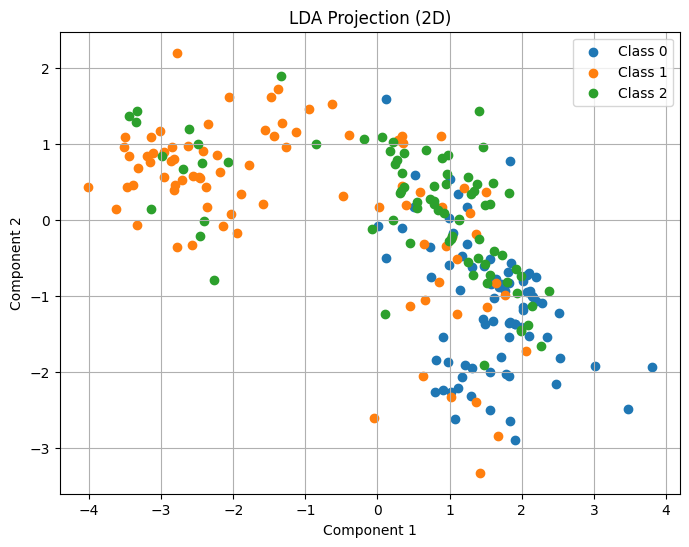

In [31]:
classes = np.unique(y_train)
print("Classes:", classes)

plt.figure(figsize=(8, 6))
for cls in classes:
    plt.scatter(
        Xc_projected[y_train == cls, 0],  # First component
        Xc_projected[y_train == cls, 1],  # Second component
        label=f"Class {cls}"
    )

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("LDA Projection (2D)")
plt.legend()
plt.grid()
plt.show()

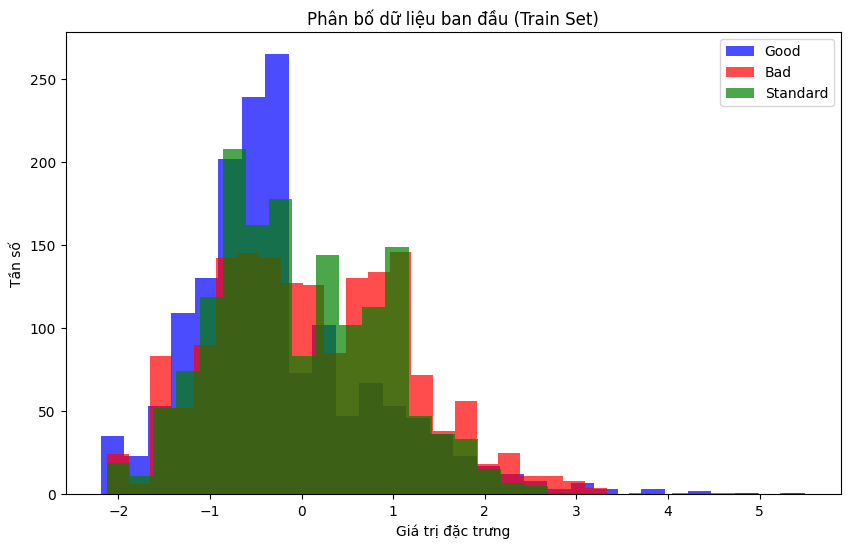

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(X_train[y_train == 0].flatten(), bins=30, alpha=0.7, label="Good", color='blue')
plt.hist(X_train[y_train == 1].flatten(), bins=30, alpha=0.7, label="Bad", color='red')
plt.hist(X_train[y_train == 2].flatten(), bins=30, alpha=0.7, label="Standard", color='green')
plt.title("Phân bố dữ liệu ban đầu (Train Set)")
plt.xlabel("Giá trị đặc trưng")
plt.ylabel("Tần số")
plt.legend()
plt.show()

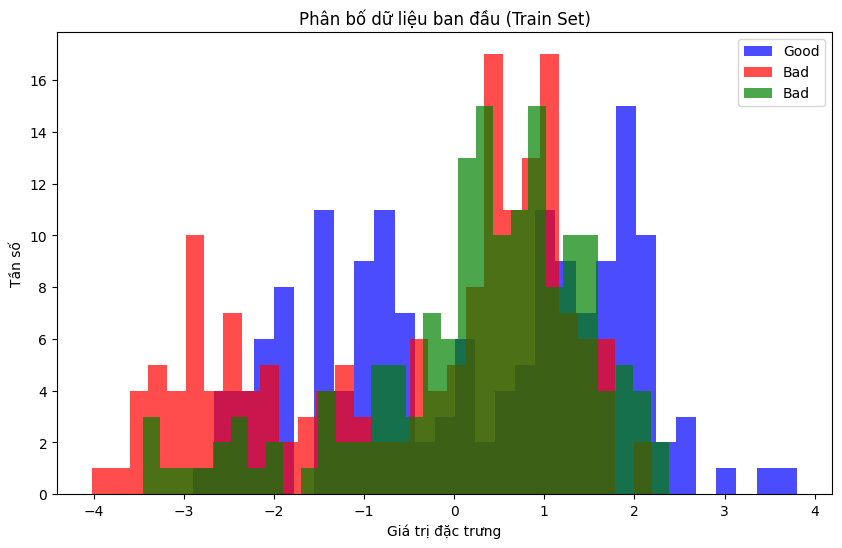

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(Xc_projected[y_train == 0].flatten(), bins=30, alpha=0.7, label="Good", color='blue')
plt.hist(Xc_projected[y_train == 1].flatten(), bins=30, alpha=0.7, label="Bad", color='red')
plt.hist(Xc_projected[y_train == 2].flatten(), bins=30, alpha=0.7, label="Bad", color='green')
plt.title("Phân bố dữ liệu ban đầu (Train Set)")
plt.xlabel("Giá trị đặc trưng")
plt.ylabel("Tần số")
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import accuracy_score

y_pred = predict_lda(X_test, W, X_train, y_train)

# Assuming y_test contains the true labels and y_pred contains the predicted labels
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 70.00%
